In [1]:
from collect_data import *
from collect_metrics import *
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

In [2]:
megsp_path = os.path.join(meg_path, 'collect_data/megsp')
audio_path = os.path.join(meg_path, 'collect_data/audio')
megsp_list = os.listdir(megsp_path)
audio_list = os.listdir(audio_path)

select_subj = "02"
megsp_list_session_0 = [f for f in megsp_list if f.startswith(select_subj) and f.split('_')[1] == '0']
megsp_list_session_1 = [f for f in megsp_list if f.startswith(select_subj) and f.split('_')[1] == '1']

In [3]:
audio_tensor_train, audio_tensor_valid, audio_tensor_test = get_splitted_tensor(audio_list, audio_path)
audio_tensor_train = torch.cat((audio_tensor_train, audio_tensor_train), 0)
audio_tensor_valid = torch.cat((audio_tensor_valid, audio_tensor_valid), 0)
audio_tensor_test = torch.cat((audio_tensor_test, audio_tensor_test), 0)
print('DIMENSION_AUDIO_TENSOR_TRAIN: ', audio_tensor_train.shape)
print('DIMENSION_AUDIO_TENSOR_VALID: ', audio_tensor_valid.shape)
print('DIMENSION_AUDIO_TENSOR_TEST: ', audio_tensor_test.shape)

meg_0_tensor_train, meg_0_tensor_valid, meg_0_tensor_test = get_splitted_tensor(megsp_list_session_0, megsp_path)
meg_1_tensor_train, meg_1_tensor_valid, meg_1_tensor_test = get_splitted_tensor(megsp_list_session_1, megsp_path)
meg_tensor_train = torch.cat((meg_0_tensor_train, meg_1_tensor_train), 0)
meg_tensor_valid = torch.cat((meg_0_tensor_valid, meg_1_tensor_valid), 0)
meg_tensor_test = torch.cat((meg_0_tensor_test, meg_1_tensor_test), 0)
print('DIMENSION_MEG_TENSOR_TRAIN: ', meg_tensor_train.shape)
print('DIMENSION_MEG_TENSOR_VALID: ', meg_tensor_valid.shape)
print('DIMENSION_MEG_TENSOR_TEST: ', meg_tensor_test.shape)


DIMENSION_AUDIO_TENSOR_TRAIN:  torch.Size([11958, 257, 376])
DIMENSION_AUDIO_TENSOR_VALID:  torch.Size([1684, 257, 376])
DIMENSION_AUDIO_TENSOR_TEST:  torch.Size([3480, 257, 376])
DIMENSION_MEG_TENSOR_TRAIN:  torch.Size([11958, 208, 16, 26])
DIMENSION_MEG_TENSOR_VALID:  torch.Size([1684, 208, 16, 26])
DIMENSION_MEG_TENSOR_TEST:  torch.Size([3480, 208, 16, 26])


In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        """
        """
        assert X.size(0) == Y.size(0), "The number of input and output samples must be the same"
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    

train_dataset = CustomDataset(audio_tensor_train, meg_tensor_train)
valid_dataset = CustomDataset(audio_tensor_valid, meg_tensor_valid)
test_dataset = CustomDataset(audio_tensor_test, meg_tensor_test)

# batch_size = 32  # --> da scegliere
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



### Single Ridge Regression

In [5]:
X_train = audio_tensor_train.reshape(audio_tensor_train.shape[0], -1)
y_train = meg_tensor_train.reshape(meg_tensor_train.shape[0], -1)
X_test = audio_tensor_test.reshape(audio_tensor_test.shape[0], -1)
y_test = meg_tensor_test.reshape(meg_tensor_test.shape[0], -1)
X_valid = audio_tensor_valid.reshape(audio_tensor_valid.shape[0], -1)
y_valid = meg_tensor_valid.reshape(meg_tensor_valid.shape[0], -1)

ridge = Ridge(alpha=5000, max_iter=10000)
ridge.fit(X_train, y_train)

pred_test_latent = ridge.predict(X_test)
train_predicted = ridge.predict(X_train)
val_predicted = ridge.predict(X_valid)

print("rmse", mean_squared_error(y_train, train_predicted))
print("rmse", mean_squared_error(y_valid, val_predicted))
print("rmse", mean_squared_error(y_test, pred_test_latent))


rmse 28.434341306011174
rmse 68.27646497559086
rmse 70.31384085931612


In [7]:
y_test_flat = y_test.reshape(-1)
ridge_predictions_flat = pred_test_latent.reshape(-1)
correlation_matrix = np.corrcoef(y_test_flat, ridge_predictions_flat)
print("Correlation matrix between actual and predicted:")
print(correlation_matrix)

Correlation matrix between actual and predicted:
[[1.         0.50532865]
 [0.50532865 1.        ]]


### Ridge Regression for every MEG channel

In [4]:
if torch.cuda.is_available():
    # Set the CUDA device (assuming you have a GPU with device index 0)
    torch.cuda.set_device(3)
    # Now, any PyTorch tensors or models you create will be allocated on GPU 0
    # Example:
    tensor_on_gpu = torch.tensor([1, 2, 3]).cuda()
    print("Tensor on GPU:", tensor_on_gpu)
else:
    print("CUDA is not available. Running on CPU.")

Tensor on GPU: tensor([1, 2, 3], device='cuda:3')


In [ ]:
pred_target = []
mse_scores = []
real_target = []
audio_train = audio_tensor_train.reshape(audio_tensor_train.shape[0], -1)
audio_test = audio_tensor_test.reshape(audio_tensor_test.shape[0], -1)

for channel in tqdm(range(num_channel)):    # 10 canali --> tempo +/- 12 minuti
    y_train = meg_tensor_train[:, channel, :, :].reshape(meg_tensor_train.shape[0], -1)
    y_test = meg_tensor_test[:, channel, :, :].reshape(meg_tensor_test.shape[0], -1)

    model = Ridge(alpha=5000, max_iter=1000)
    model.fit(audio_train, y_train)

    y_pred = model.predict(audio_test)
    mse = mean_squared_error(y_test, y_pred)
    pred_target.append(y_pred)
    real_target.append(y_test)
    mse_scores.append(mse)

    


In [13]:
# save_pred_target = os.path.join(meg_path, 'collect_data/meg_prediction_ridge.pt')
# torch.save(torch.tensor(pred_target), save_pred_target)
# save_mse = os.path.join(meg_path, 'collect_data/meg_mse_ridge.pt')
# torch.save(torch.tensor(mse_scores), save_mse)

In [4]:
pred_mse_scores = torch.load(os.path.join(meg_path, 'collect_data/meg_mse_ridge.pt'))
pred_meg_y = torch.load(os.path.join(meg_path, 'collect_data/meg_prediction_ridge.pt'))
pred_meg_y, real_target, correlations = get_correlation(meg_tensor_test, pred_meg_y)

print("PREDICTION_SHAPE:", pred_meg_y.shape)
print("DIAG_CORRELATION_MATRIX", correlations)

PREDICTION_SHAPE: torch.Size([3480, 208, 416])
DIAG_CORRELATION_MATRIX [0.44687414 0.38193695 0.15102686 0.37346252 0.38620107 0.18739323
 0.2621355  0.33459648 0.42631936 0.24307491 0.31513486 0.43078534
 0.51346364 0.38469357 0.34757442 0.22370144 0.52735921 0.33150846
 0.26497303 0.5038545  0.31064132 0.38748161 0.37840857 0.47729897
 0.3466337  0.44346605 0.43302488 0.36690972 0.41160963 0.44343872
 0.55546912 0.18003945 0.52949312 0.30446504 0.49563585 0.46965793
 0.5238229  0.49788574 0.47461802 0.48416812 0.44752585 0.27929566
 0.42802519 0.4353812  0.35027737 0.16427001 0.39857906 0.41122491
 0.49906795 0.57045929 0.45420744 0.47826167 0.59620553 0.3700844
 0.4797922  0.41630026 0.54132602 0.5232327  0.56051816 0.41181102
 0.57784775 0.55625074 0.45933961 0.34983073 0.52532543 0.5799275
 0.31233193 0.43757619 0.41696369 0.55177796 0.4772894  0.33663973
 0.52937101 0.43198374 0.52372959 0.5222248  0.53861199 0.42435252
 0.20356156 0.51465786 0.31310322 0.48894936 0.51679934 0.52

Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/home/matteoc/spect-to-meg/code/collect_data.py:49: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


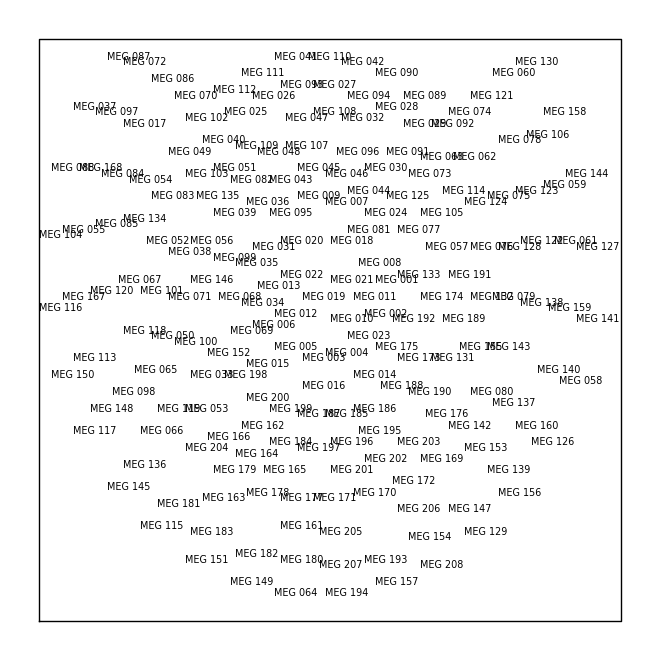

Figure(640x640)


In [5]:
raw = get_bids_raw(meg_path, patient[0], session[0], '0')
layout_from_raw = mne.channels.find_layout(raw.info, ch_type='mag')
print(layout_from_raw.plot())


In [7]:
pred_mae_scores = list(0.8 * np.sqrt(np.array(pred_mse_scores)))

In [ ]:
get_topomap(raw, pred_mae_scores, (5.2, 8), 'RdYlGn_r', None, 'auto', 1)

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


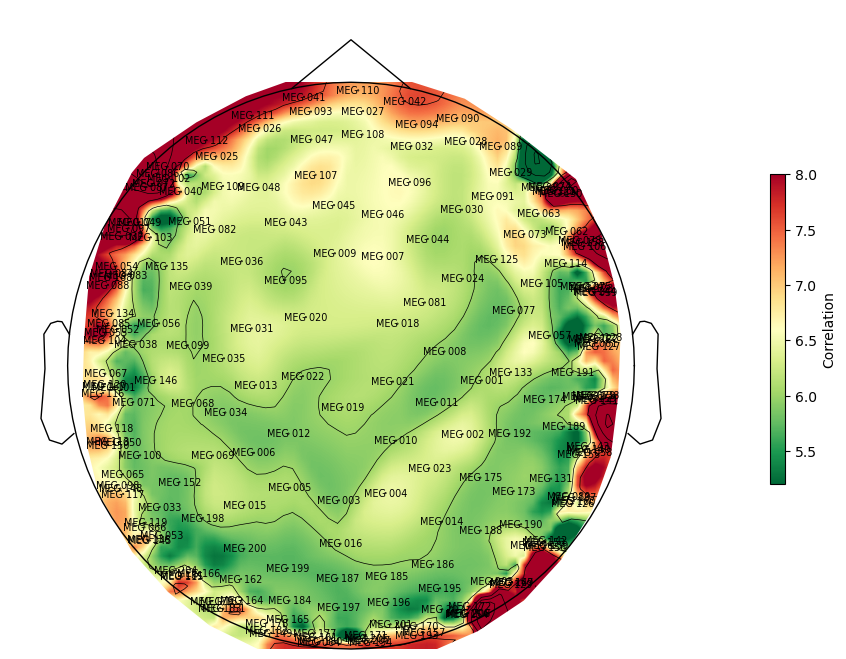

In [8]:
get_topomap(raw, pred_mae_scores, (5.2, 8), 'RdYlGn_r')

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


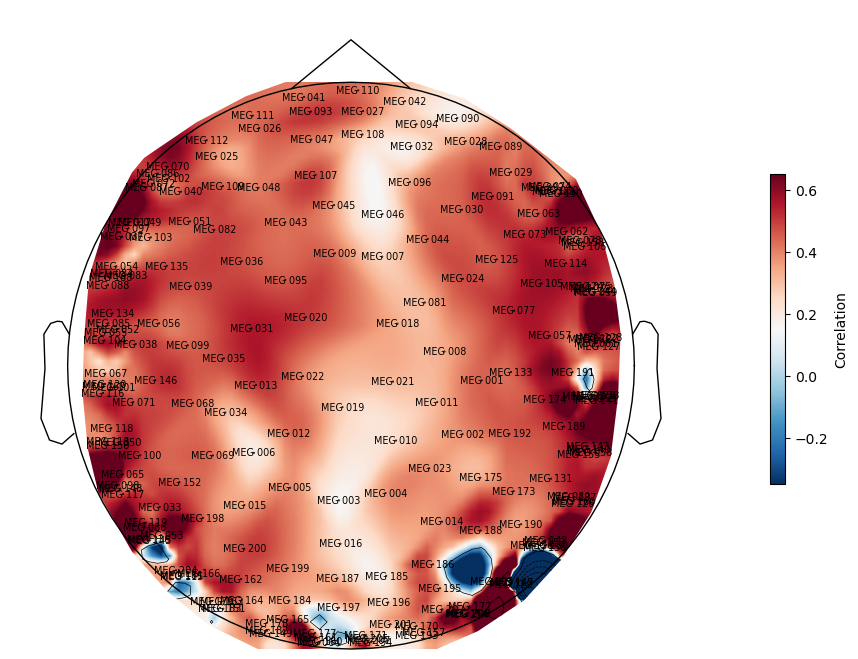

In [7]:
get_topomap(raw, correlations, (-0.35, 0.65))

In [5]:
pred_meg_y = pred_meg_y.reshape(-1, num_channel, 16, 26)
real_target = real_target.reshape(-1, num_channel, 16, 26)
print(pred_meg_y.shape)
print(real_target.shape)

torch.Size([3480, 208, 16, 26])
torch.Size([3480, 208, 16, 26])


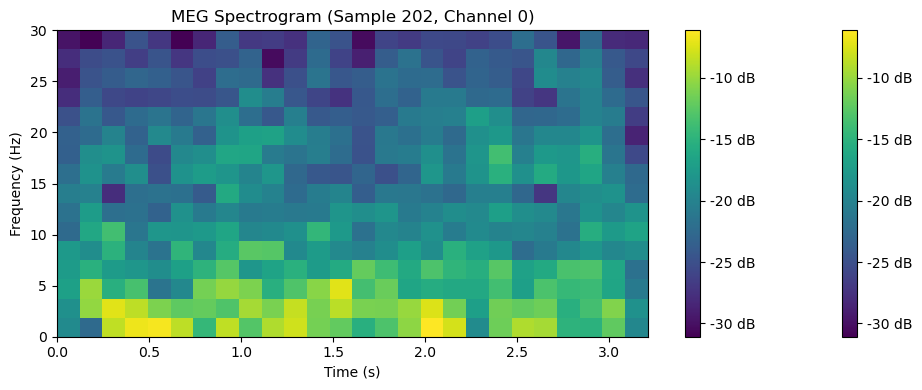

In [8]:
plot_spectrogram(pred_meg_y, sampling_meg, 202, 0)

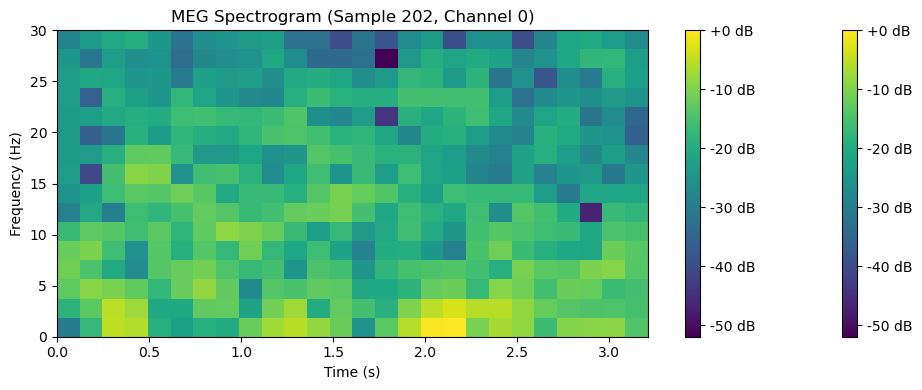

In [9]:
plot_spectrogram(real_target, sampling_meg, 202, 0)

### Estimate the cross power spectral density

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 26, using nperseg = 26
  warnings.warn('nperseg = {0:d} is greater than input length '


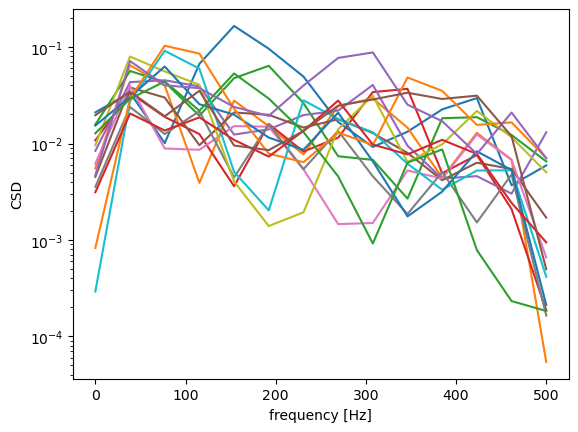

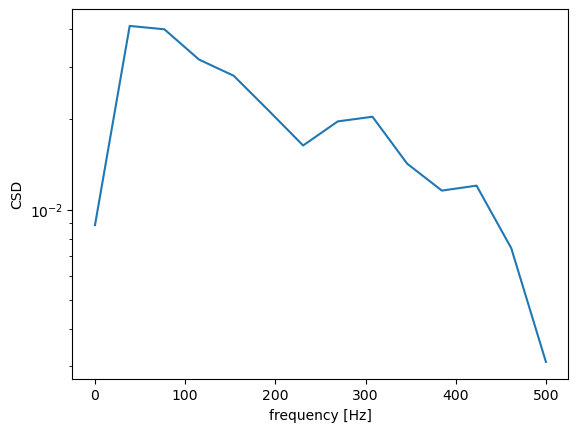

In [12]:
from scipy import signal

real_meg_202 = real_target[202, 0, :, :]
pred_meg_202 = pred_meg_y[202, 0, :, :]

assert real_meg_202.shape == pred_meg_202.shape
f, Pxy = signal.csd(real_meg_202, pred_meg_202, sampling_meg, scaling='density', average='mean')

plt.semilogy(f, np.abs(Pxy).T)
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD')
plt.show()

plt.semilogy(f, np.mean(np.abs(Pxy).T, axis=1))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD')
plt.show()



## All metrics

In [10]:
# PEARSON PIXEL CORRELATION

pixel_corr = get_pixel_corr(real_target, pred_meg_y)
print("DIAG_PIX_CORRELATION_MATRIX", pixel_corr.shape)



DIAG_PIX_CORRELATION_MATRIX (208, 416)


In [8]:
real_target = real_target.reshape(real_target.shape[0], real_target.shape[1], 16, 26)
pred_meg_y = pred_meg_y.reshape(pred_meg_y.shape[0], pred_meg_y.shape[1], 16, 26)

In [9]:
# FREQUENCY BANDS METRICS

freq_bands = {
    'delta': [0, 2],
    'theta': [2, 4],
    'alpha': [4, 7],
    'beta': [7, 16],
}

metrics_by_band = bands_metrics(real_target, pred_meg_y, freq_bands)

for band_name, metrics_list in metrics_by_band.items():
    print(f'Metrics for {band_name} band:')
    for metrics in metrics_list:
        print(f"Channel {metrics['channel']}: Pearson Corr {metrics['pearson_corr']:.4f}, Sci_R^2 {metrics['scikit_r2']:.4f}, Mod_R^2 {metrics['modified_r2']:.4f}, MSE {metrics['mse']:.4f}, MAE {metrics['mae']:.4f}, MAE_Norm {metrics['mae_norm']:.4f}")



Metrics for delta band:
Channel 0: Pearson Corr 0.2575, Sci_R^2 -0.1909, Mod_R^2 0.0663, MSE 68.8445, MAE 6.1478, MAE_Norm 0.5321
Channel 1: Pearson Corr 0.1627, Sci_R^2 -0.1907, Mod_R^2 0.0265, MSE 69.0510, MAE 6.1591, MAE_Norm 0.5276
Channel 2: Pearson Corr -0.3599, Sci_R^2 -0.1780, Mod_R^2 -0.1295, MSE 69.1766, MAE 6.1360, MAE_Norm 0.5290
Channel 3: Pearson Corr 0.2796, Sci_R^2 -0.1867, Mod_R^2 0.0782, MSE 68.9056, MAE 6.1709, MAE_Norm 0.5187
Channel 4: Pearson Corr 0.0006, Sci_R^2 -0.1831, Mod_R^2 0.0000, MSE 69.7770, MAE 6.1541, MAE_Norm 0.5330
Channel 5: Pearson Corr 0.0755, Sci_R^2 -0.1863, Mod_R^2 0.0057, MSE 70.1513, MAE 6.1716, MAE_Norm 0.5328
Channel 6: Pearson Corr 0.0787, Sci_R^2 -0.1860, Mod_R^2 0.0062, MSE 71.4787, MAE 6.3110, MAE_Norm 0.5169
Channel 7: Pearson Corr -0.0253, Sci_R^2 -0.1818, Mod_R^2 -0.0006, MSE 69.6318, MAE 6.1704, MAE_Norm 0.5292
Channel 8: Pearson Corr 0.0270, Sci_R^2 -0.1897, Mod_R^2 0.0007, MSE 71.7203, MAE 6.3167, MAE_Norm 0.5226
Channel 9: Pearson

In [19]:
delta_corr = [entry['pearson_corr'] for entry in metrics_by_band['delta']]
theta_corr = [entry['pearson_corr'] for entry in metrics_by_band['theta']]
alpha_corr = [entry['pearson_corr'] for entry in metrics_by_band['alpha']]
beta_corr = [entry['pearson_corr'] for entry in metrics_by_band['beta']]

print('MIN delta_corr: ',min(delta_corr))
print('MIN theta_corr: ',min(theta_corr))
print('MIN alpha_corr: ',min(alpha_corr))
print('MIN beta_corr: ',min(beta_corr))

print('MAX delta_corr: ',max(delta_corr))
print('MAX theta_corr: ',max(theta_corr))
print('MAX alpha_corr: ',max(alpha_corr))
print('MAX beta_corr: ',max(beta_corr))


MIN delta_corr:  -0.35990561692071404
MIN theta_corr:  -0.3246489444164028
MIN alpha_corr:  -0.2866931786486755
MIN beta_corr:  -0.13222481398605676
MAX delta_corr:  0.7644616620414203
MAX theta_corr:  0.4510901999383976
MAX alpha_corr:  0.4374414483147002
MAX beta_corr:  0.3808145037761875


meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


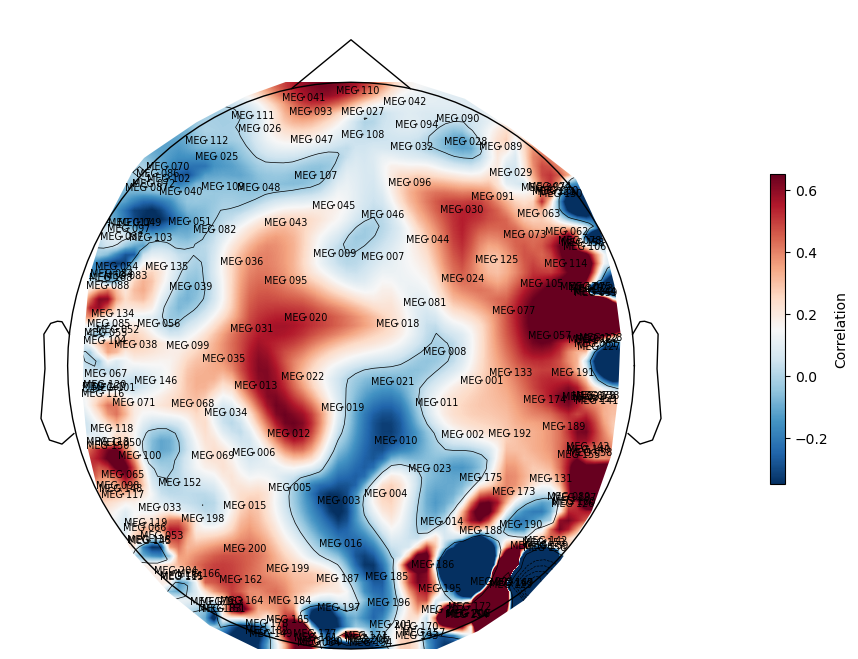

In [20]:
get_topomap(raw, delta_corr, (-0.35, 0.65))

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


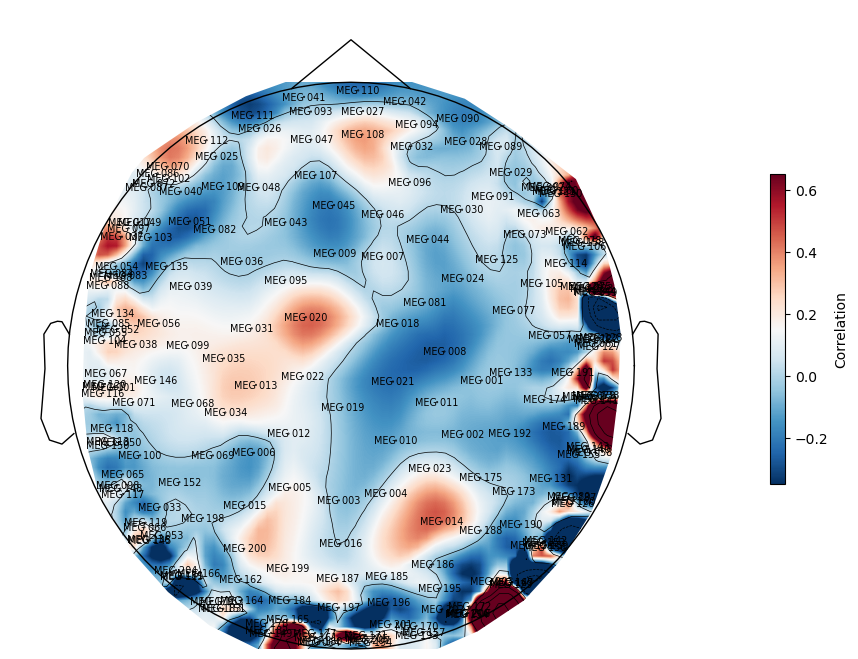

In [21]:
get_topomap(raw, theta_corr, (-0.35, 0.65))

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


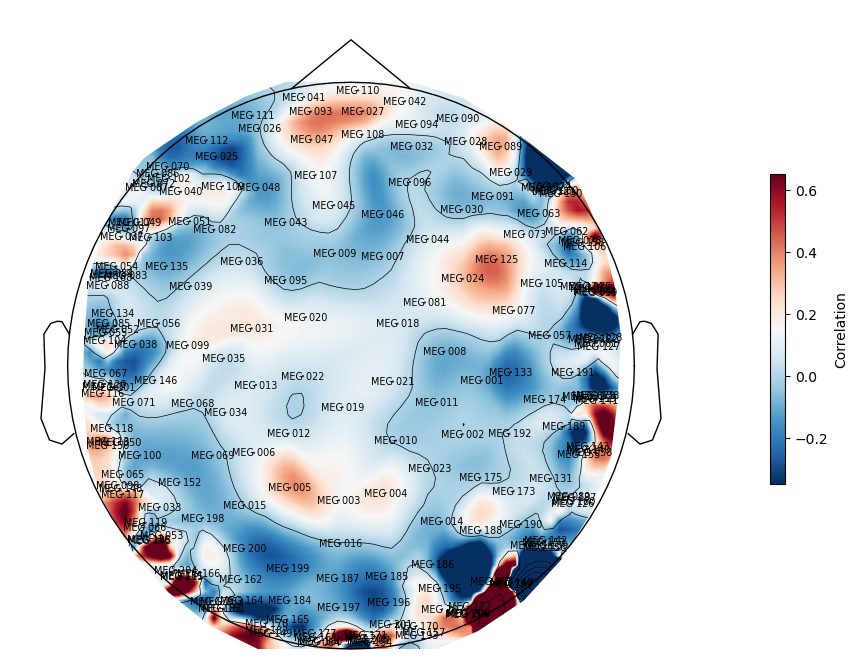

In [22]:
get_topomap(raw, alpha_corr, (-0.35, 0.65))

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


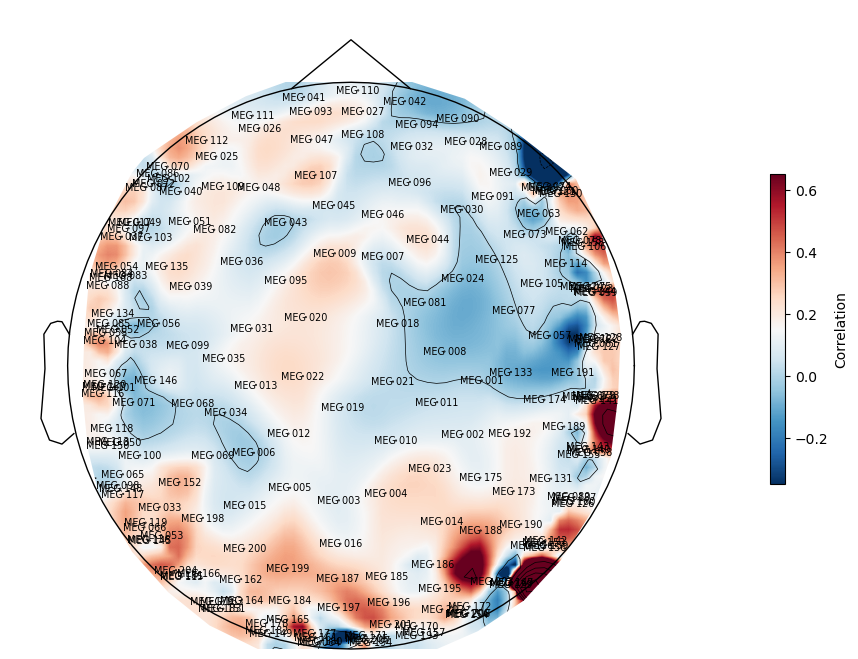

In [23]:
get_topomap(raw, beta_corr, (-0.35, 0.65))

### Kullback Divergence

In [6]:
kullback_vect = get_kullback_vect(pred_meg_y, real_target)

In [7]:
kullback_vect

array([0.11055466, 0.09595714, 0.17697813, 0.13131803, 0.10146103,
       0.11077527, 0.14608749, 0.12017305, 0.13339047, 0.15335929,
       0.1243568 , 0.13360828, 0.10842102, 0.11203271, 0.09898307,
       0.11691107, 0.18247195, 0.14092776, 0.15370362, 0.13221893,
       0.14044604, 0.11860074, 0.11188649, 0.1235572 , 0.18536832,
       0.19011357, 0.13044318, 0.14168965, 0.12162103, 0.14520228,
       0.1143561 , 0.1501833 , 0.09131085, 0.12050414, 0.10776148,
       0.15113635, 0.12822036, 0.1133526 , 0.11629663, 0.16704786,
       0.15508104, 0.15740366, 0.13245417, 0.14221084, 0.14800553,
       0.15665675, 0.14167233, 0.156217  , 0.16725681, 0.11142089,
       0.14064908, 0.1205416 , 0.09258267, 0.14891273, 0.10343631,
       0.14766519, 0.12383993, 0.06014423, 0.10332389, 0.14904327,
       0.10086672, 0.13066877, 0.12207758, 0.09127546, 0.10399862,
       0.06372657, 0.14409319, 0.10637875, 0.11636167, 0.21044758,
       0.10703253, 0.26403295, 0.15126655, 0.15305501, 0.12823

### Plotting MAE

In [7]:
delta_mae = [entry['mae'] for entry in metrics_by_band['delta']]    # ['mse']
theta_mae = [entry['mae'] for entry in metrics_by_band['theta']]
alpha_mae = [entry['mae'] for entry in metrics_by_band['alpha']]
beta_mae = [entry['mae'] for entry in metrics_by_band['beta']]

In [8]:
print('mean delta_mae: ',np.mean(delta_mae))
print('mean theta_mae: ',np.mean(theta_mae))
print('mean alpha_mae: ',np.mean(alpha_mae))
print('mean beta_mae: ',np.mean(beta_mae))

print('std delta_mae: ',np.std(delta_mae))
print('std theta_mae: ',np.std(theta_mae))
print('std alpha_mae: ',np.std(alpha_mae))
print('std beta_mae: ',np.std(beta_mae))


mean delta_mae:  6.28206259405223
mean theta_mae:  6.00579557581787
mean alpha_mae:  6.2228678438028915
mean beta_mae:  6.19862143998444
std delta_mae:  0.11033024057813513
std theta_mae:  0.8706534335252772
std alpha_mae:  0.8391140888845
std beta_mae:  0.8296207876611883


In [8]:
print('mean complete_mae: ',np.mean(pred_mae_scores))
print('std complete_mae: ',np.std(pred_mae_scores))

mean complete_mae:  6.638298880711688
std complete_mae:  0.9714490246980724


meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


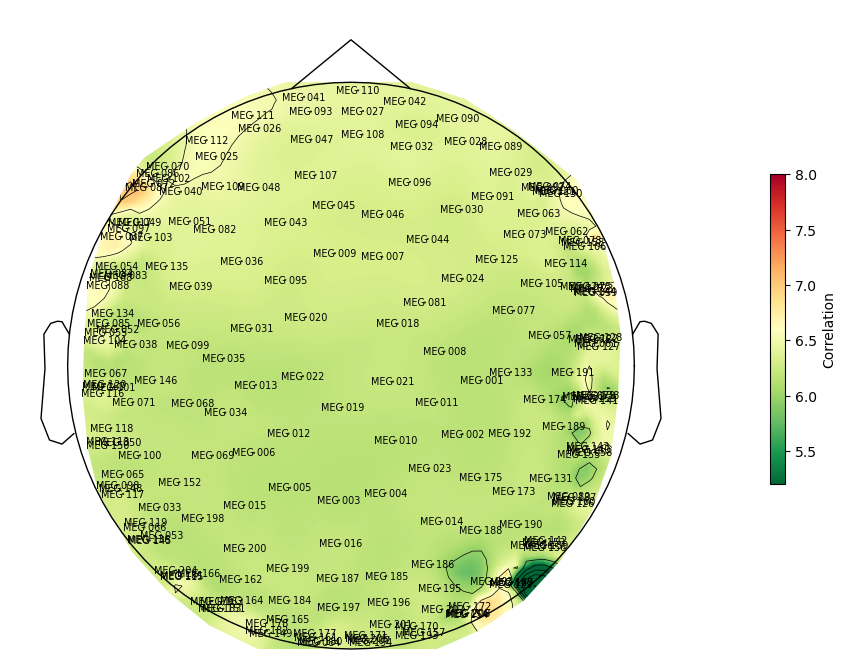

In [11]:
get_topomap(raw, delta_mae, (5.2, 8), 'RdYlGn_r')

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


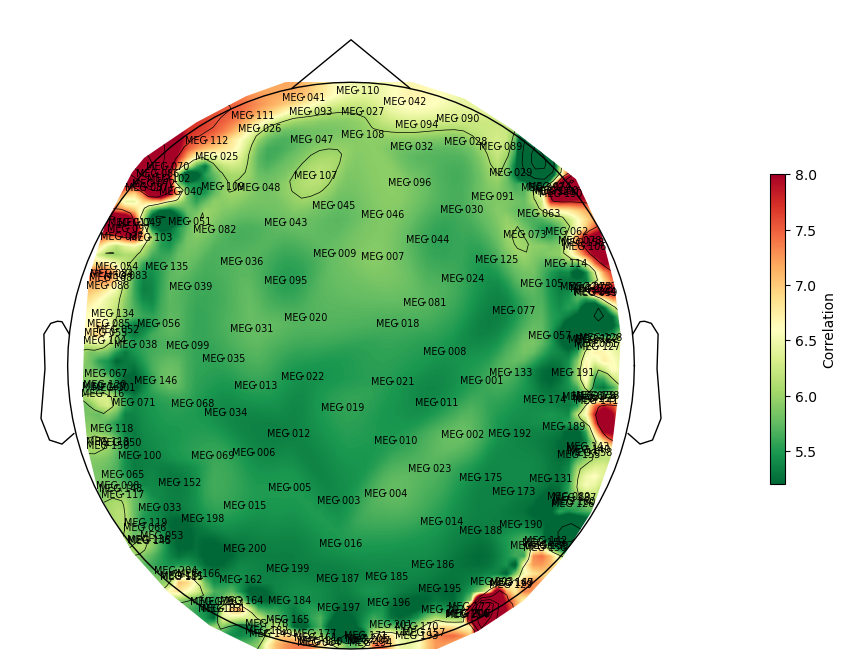

In [12]:
get_topomap(raw, theta_mae, (5.2, 8), 'RdYlGn_r')

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


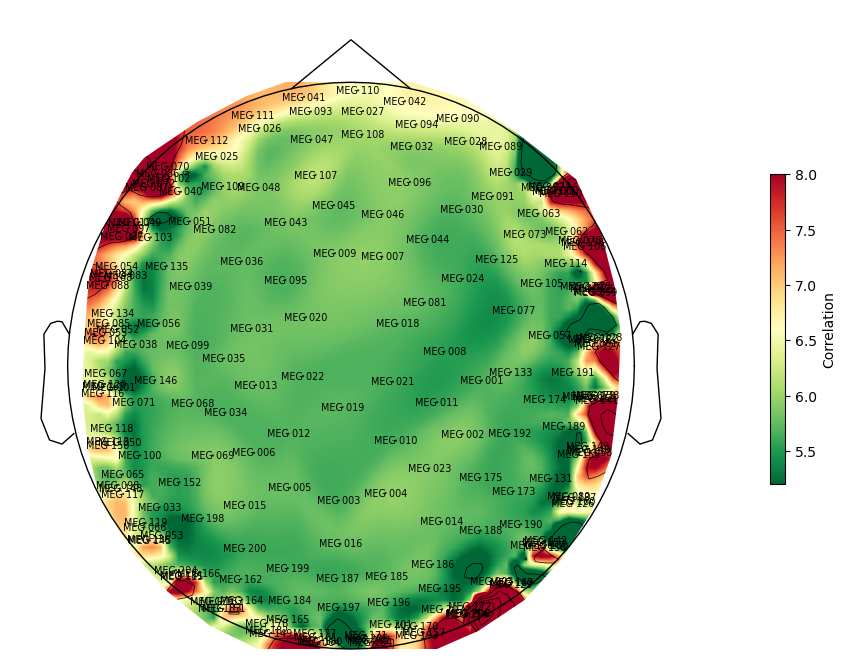

In [13]:
get_topomap(raw, alpha_mae, (5.2, 8), 'RdYlGn_r')

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


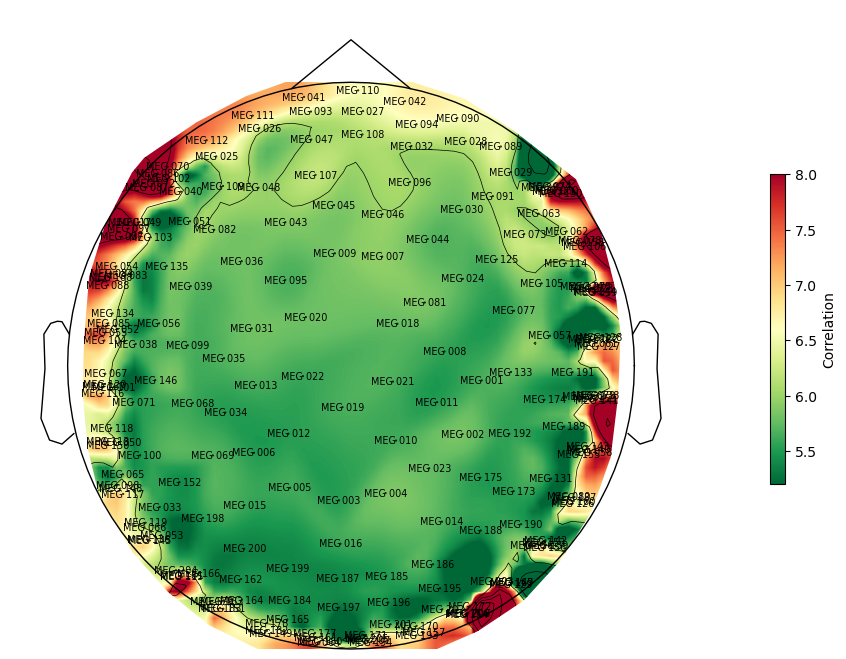

In [14]:
get_topomap(raw, beta_mae, (5.2, 8), 'RdYlGn_r')

In [15]:
delta_r2 = [entry['modified_r2'] for entry in metrics_by_band['delta']]
theta_r2 = [entry['modified_r2'] for entry in metrics_by_band['theta']]
alpha_r2 = [entry['modified_r2'] for entry in metrics_by_band['alpha']]
beta_r2 = [entry['modified_r2'] for entry in metrics_by_band['beta']]

In [26]:
print('MEAN delta_r2: ',np.mean(delta_r2))
print('MEAN theta_r2: ',np.mean(theta_r2))
print('MEAN alpha_r2: ',np.mean(alpha_r2))
print('MEAM beta_r2: ',np.mean(beta_r2))

print('STD delta_r2: ',np.std(delta_r2))
print('STD theta_r2: ',np.std(theta_r2))
print('STD alpha_r2: ',np.std(alpha_r2))
print('STD beta_r2: ',np.std(beta_r2))

MEAN delta_r2:  0.08984018697382856
MEAN theta_r2:  0.009599287587844146
MEAN alpha_r2:  0.007861218146353401
MEAM beta_r2:  0.02765936521638778
STD delta_r2:  0.12657296032313672
STD theta_r2:  0.039409354212299776
STD alpha_r2:  0.03642563157802628
STD beta_r2:  0.0301985842586005


In [9]:
pred_r2_scores = list(np.abs(correlations) * correlations)
print('mean complete_r2: ',np.mean(pred_r2_scores))
print('std. complete_r2: ',np.std(pred_r2_scores))

mean complete_r2:  0.19549278757454716
std. complete_r2:  0.08071750441411613


### Plotting MAE norm

In [35]:
delta_mae_n = [entry['mae_norm'] for entry in metrics_by_band['delta']]    
theta_mae_n = [entry['mae_norm'] for entry in metrics_by_band['theta']]
alpha_mae_n = [entry['mae_norm'] for entry in metrics_by_band['alpha']]
beta_mae_n = [entry['mae_norm'] for entry in metrics_by_band['beta']]

print('mean delta_mae: ',np.mean(delta_mae_n))
print('mean theta_mae: ',np.mean(theta_mae_n))
print('mean alpha_mae: ',np.mean(alpha_mae_n))
print('mean beta_mae: ',np.mean(beta_mae_n))

print('std delta_mae: ',np.std(delta_mae_n))
print('std theta_mae: ',np.std(theta_mae_n))
print('std alpha_mae: ',np.std(alpha_mae_n))
print('std beta_mae: ',np.std(beta_mae_n))


mean delta_mae:  0.5296336000873647
mean theta_mae:  0.33161502523566216
mean alpha_mae:  0.30324660052192887
mean beta_mae:  0.2483398089550759
std delta_mae:  0.009008032904748263
std theta_mae:  0.019300568679623226
std alpha_mae:  0.03464032844897569
std beta_mae:  0.017984886251410367


meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


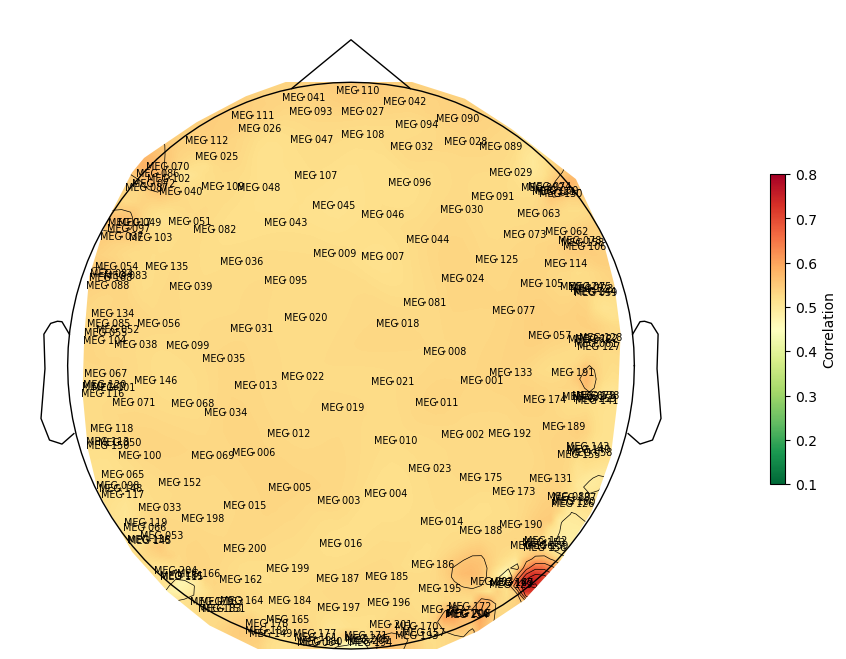

In [36]:
get_topomap(raw, delta_mae_n, (0.1, 0.8), 'RdYlGn_r')

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


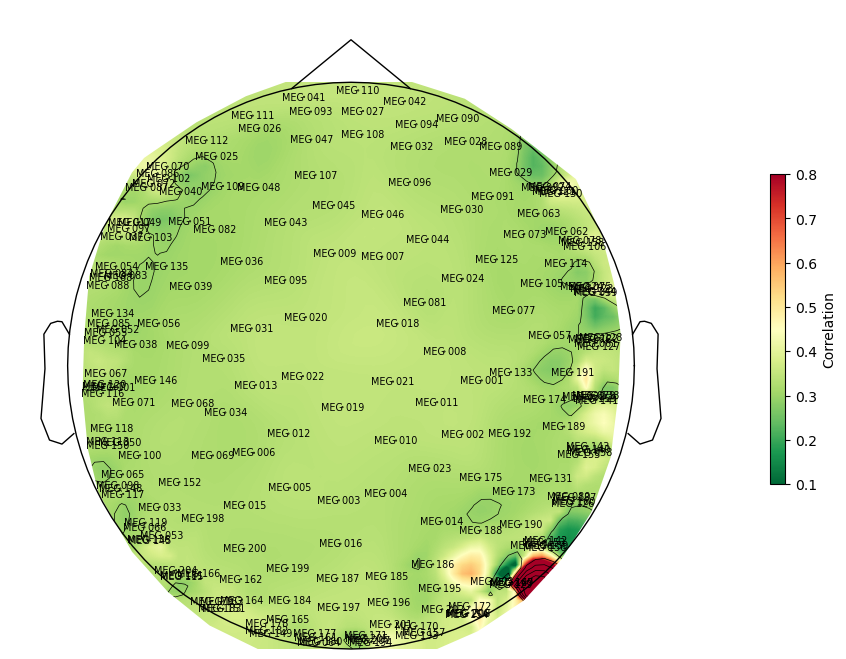

In [37]:
get_topomap(raw, theta_mae_n, (0.1, 0.8), 'RdYlGn_r')

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


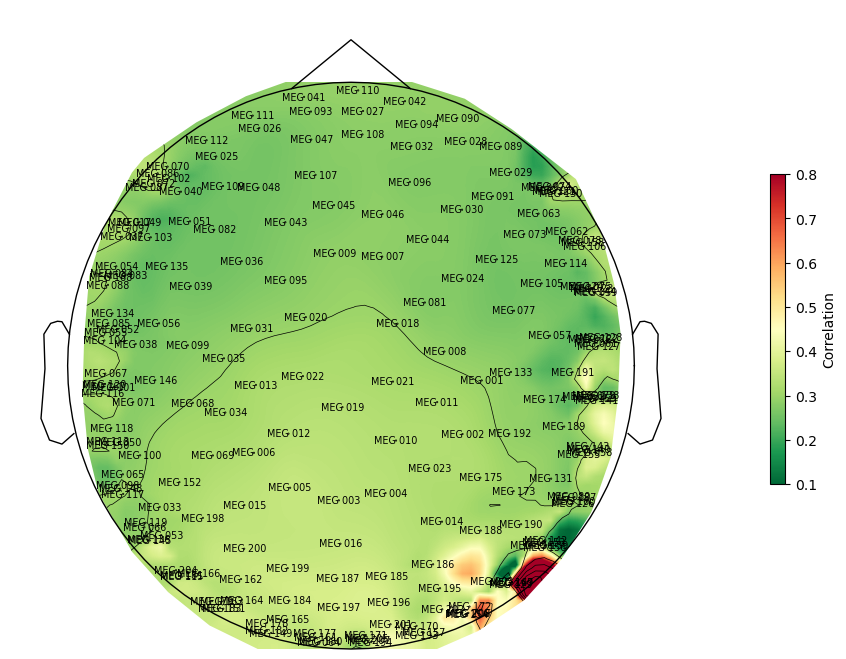

In [38]:
get_topomap(raw, alpha_mae_n, (0.1, 0.8), 'RdYlGn_r')

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


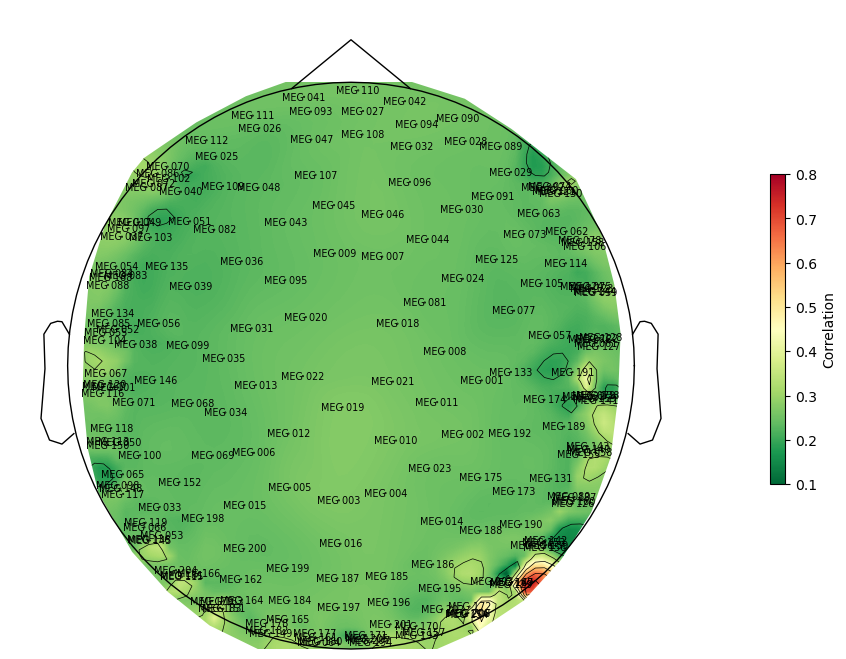

In [39]:
get_topomap(raw, beta_mae_n, (0.1, 0.8), 'RdYlGn_r')

In [6]:
mae_complete = []
for i in range(num_channel):
        pred_for_mae = pred_meg_y.reshape(pred_meg_y.shape[0], pred_meg_y.shape[1], -1)
        pred_mae_i = 0.8 * np.sqrt(np.array(pred_mse_scores[i]))
        mae_norm_i = pred_mae_i/abs(pred_for_mae[:,i].mean())
        mae_complete.append(mae_norm_i)


In [8]:
print('mean comp_mae: ',np.mean(mae_complete))
print('std comp_mae: ',np.std(mae_complete))
print('min comp_mae: ',np.min(mae_complete))
print('max comp_mae: ',np.max(mae_complete))

mean comp_mae:  0.3059842993479502
std comp_mae:  0.022625806097159754
min comp_mae:  0.2664367596445066
max comp_mae:  0.38184307467653855


meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


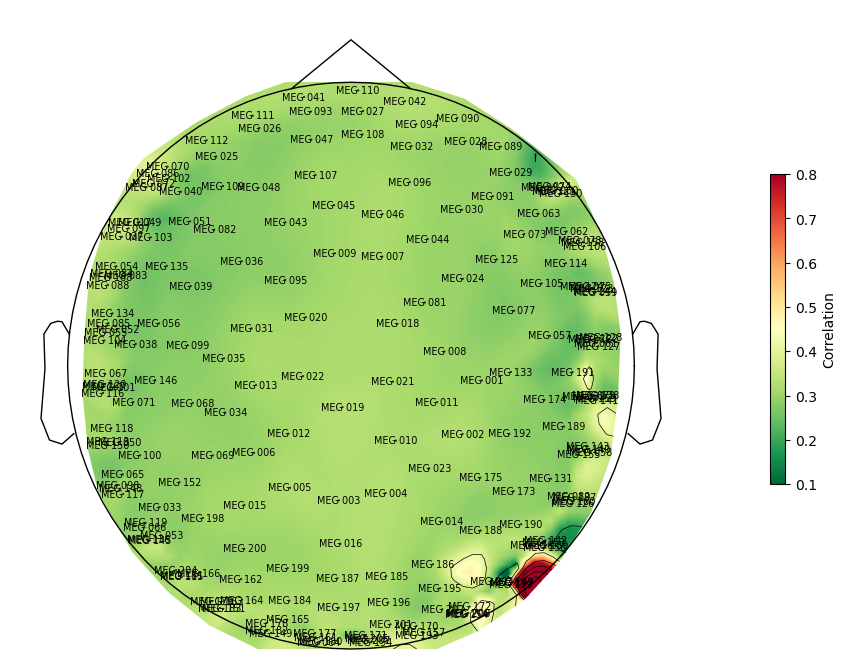

In [9]:
get_topomap(raw, mae_complete, (0.1, 0.8), 'RdYlGn_r')